## CPSC 663 Assignment 4

## Problem 1

In this problem, you will review some of the unique parameters involved in the construction of convolutional neural networks (CNNs). Then you will train a CNN on MNIST using the code provided in p1.py and visualize a sample of the learned filters of the network.

### 1.1
Tracking the dimensionality of representations as they pass through the CNN is slightly different than for fully-connected networks. For the following, give the final output dimensions in terms of height $h$ and width $w$ if the size of the input image is $50
\times 50 (h \times w)$. Here $k$, $s$, and $p$ refer to kernel size, stride and padding, respectively. For a) and b), assume the image is passing through a convolutional layer while for c) and d), assume a max-pooling layer. Assume a square kernel. (This [link text](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) is a helpful visualization.)

(a) $k=4, s=1, p=1$

(b) $k=8, s=5, p=0$

(c) $k=10, s=2, p=2$

(d) $k=2, s=1, p=0$

The formulas relating the output shape of the convolution to the input shape is

$$
\begin{array}{c}n_{H}=\left\lfloor\frac{{n_H}_{\text {prev }}-f+2 \times p a d}{\text { stride }}\right\rfloor+1 \\ 
n_{W}=\left\lfloor\frac{{n_W}_{\text {prev }}-f+2 \times p a d}{\text { stride }}\right\rfloor+1 \\ 
n_{C}=\text { number of filters used in the convolution }
\end{array}
$$

(a) $$n_H = \lfloor(50-4+2)/1\rfloor + 1 = 49, n_W = \lfloor(50-4+2)/1\rfloor + 1 = 49$$

(b) $$n_H = \lfloor(49-8 + 0)/5\rfloor + 1 = 8+1 = 9 = n_W$$

(c) $$n_H = \lfloor(9- 10 + 4 )/2\rfloor + 1 = 1+1 = 2 = n_W$$

(d) $$n_H = \lfloor(2- 2 + 0 )/1\rfloor + 1 = 0+1 = 1 = n_W$$

### 1.2
This following questions can be answered by looking at the provided code in p1.py

(a) Train the model for 5 epochs. Visualize filters from the first convolutional layer (40 filters total).
Include this image in your report.

(b) Produce a confusion matrix using the test split and comment on any noticeable class confusion (one class is commonly mislabeled as the other). You may use the sklearn for this. Include the plot in your report.


In [ ]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import torchvision

import sys
sys.argv=['']
del sys

# from einops import rearrange, reduce

# DESCRIBing THE CNN ARCHITECTURE 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 5, 1)
        self.conv2 = nn.Conv2d(40, 80, 5, 1)
        self.fc1 = nn.Linear(4*4*80, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*80)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
   
def train(args, model, device, train_loader, optimizer, epoch):

    # ANNOTATION 1
    model.train()

    # ANNOTATION 2
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # ANNOTATION 3
        optimizer.zero_grad()
        output = model(data)

        # ANNOTATION 4
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader, epoch):

    model.eval()
    test_loss = 0
    correct = 0

    # stop tracking gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    #############################################
    # TODO: on final epoch, extract filters from model.conv1 and save them 
    # as an image. 
    # you can use the "save_image" function for this
    # get samples
    #############################################


    # fill in code here      

if __name__ == '__main__':
        # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=5, metavar='N',
                        help='number of epochs to train (default: 5)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=True,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
   
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    # dat = torchvision.datasets.FashionMNIST('./data', train=False,
    #                         transform=transforms.Compose([
    #                        transforms.ToTensor(),
    #                        transforms.Normalize((0.1307,), (0.3081,))
    #                    ])),

    model = CNN().to(device)

    # ANNOTATION 6
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader, epoch)

    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337240
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.198580
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.984464
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.571951
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.255146
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.923955
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.686679
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.660238
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.480767
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.361866
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.283521
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.403073
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.464262
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.303864
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.273299
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.421047
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.242251
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.419301
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.352675
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.465401
Train Epoch: 1 [12800/60000 (

In [ ]:
import matplotlib.pyplot as plt

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]
    ncols = 8
    
    nrows = nplots/ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, 0].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title('Kernel ' + str(i))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

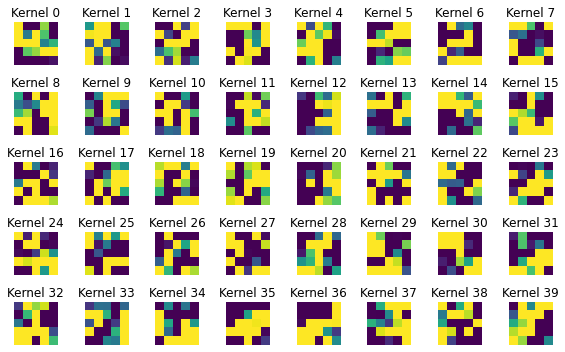

In [ ]:
weight_tensor = model.conv1.weight.data
#print(weight_tensor.shape)
plot_filters_single_channel(weight_tensor)

In [ ]:
model.eval()
test_loss = 0
correct = 0

target_all = torch.zeros(0, 1)
pred_all = torch.zeros(0, 1)

# stop tracking gradients
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        target_all = torch.cat((target_all, target.view_as(pred)), dim=0)
        pred_all = torch.cat((pred_all, pred), dim=0)

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0415, Accuracy: 9865/10000 (99%)



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_all, pred_all)
cm

array([[ 974,    0,    0,    0,    0,    0,    2,    1,    3,    0],
       [   0, 1120,    2,    1,    0,    1,    2,    1,    8,    0],
       [   1,    0, 1027,    0,    0,    0,    0,    1,    3,    0],
       [   1,    0,    1, 1002,    0,    2,    0,    1,    3,    0],
       [   0,    0,    3,    0,  973,    0,    3,    0,    1,    2],
       [   2,    0,    1,   11,    0,  874,    1,    1,    2,    0],
       [   3,    1,    0,    1,    1,    3,  948,    0,    1,    0],
       [   1,    2,   12,    5,    0,    0,    0, 1004,    2,    2],
       [   1,    0,    1,    2,    0,    0,    1,    0,  969,    0],
       [   5,    2,    0,   10,    1,    3,    1,    3,   10,  974]])

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 974    0    0    0    0    0    2    1    3    0]
 [   0 1120    2    1    0    1    2    1    8    0]
 [   1    0 1027    0    0    0    0    1    3    0]
 [   1    0    1 1002    0    2    0    1    3    0]
 [   0    0    3    0  973    0    3    0    1    2]
 [   2    0    1   11    0  874    1    1    2    0]
 [   3    1    0    1    1    3  948    0    1    0]
 [   1    2   12    5    0    0    0 1004    2    2]
 [   1    0    1    2    0    0    1    0  969    0]
 [   5    2    0   10    1    3    1    3   10  974]]


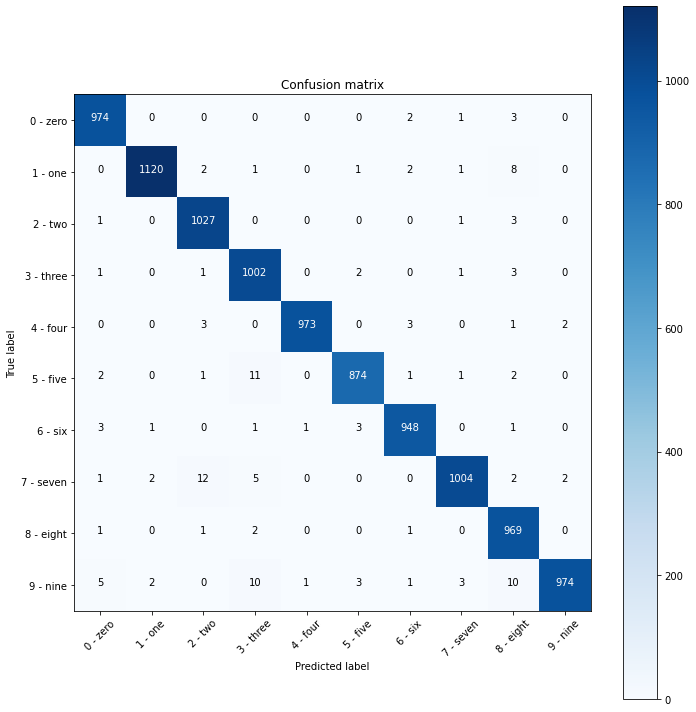

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, test_loader.dataset.classes)

## Problem 2

### 2.1
Principal Component Analysis (PCA) is a very common method for dimensionality reduction. Conceptually, describe how the principal components in PCA are chosen. If PCA is to implemented in PyTorch, the function torch.svd() will play an important role in the algorithm. Please briefly describe what this function does, and why the results will be useful in implementing PCA.

Describe how the principal components in PCA are chosen.
- Answer: Principal components are new variables that are constructed as linear combinations of the initial variables. The new variables contains the most of information of the original variables. It represents the directions of the data that explains a maximum amount of variance. For example, the first principal component gives the direction of the maximum variance. The second principle component represents the second maximum variance and the direction is prependicular to the direction of the first principle component. PCA uses eigendecomposition. The eigenvectors determine the direction of the principle components, and the eigenvalues determine the magnitude.

Describe what [torch.svd()](https://pytorch.org/docs/stable/generated/torch.svd.html) does.
- Answer: The function computes the singular value decomposition of either a matrix or batch of matrices input. The singular value decomposition is represented as a named tuple $(U,S,V)$, such that $input = U \text{diag}(S) V^T$, where $V^T$ is the transpose of $V$ for the real-valued inputs, or the conjugate transpose of $V$ for the complex-valued inputs. 

Why the results will be useful in implementing PCA.
- Answer: Take SVD of the design matrix $X$, we have $X = U S V^T$ where $U^TU=I$ AND $VV^T=I$. Then 
$$X^X = VS^TU^TUSV^T = VS^TSV^T = VDV^T$$ where $D = S^TS$ which is the diagnoal with squares of singular values. Then
$$ (X^TX)V = VD.$$ This equation is the eigenvalue equation. $X^TX$ is the scaled covariance matrix. So to get the projection vectors for PCA, we actually calculated the eigenvalues and eigenvectors for the sample covaraince matrix. We can get all of the eigenvalues and eigenvectors by just doing the SVD of the sample covariance matrix by just using one line `torch.svd()`.

### 2.2
Describe the similarity between PCA and an autoencoder.

Answer: (1) Both are unsupervised learning methods. (2) Both can be used for dimensionality reduction. (3) The performance of a single-layer autoencoder with a linear activation function encode the same subspace as PCA. (But a multi-layer autoencoder with a nonlinear activation function can have a better performance.)

Some differences include (1) In the encoding process, the autoencoder can perform linear and non-linear transformations, while PCA can only perform linear transformations. (2) Since the PCA algorithm is old and mature, the calculation is fast. The autoencoder needs to be trained by the gradient descent algorithm, so it takes longer. (3) PCA projects the data in orthogonal directions, while not for autoencoder. (4) The only hyperparameter of PCA is the number of principle components; the hyperparameter of autoencoder is the hyperparameter of neural network.

### 2.3
What is the difference between a convolutional autoencoder and linear autoencoder? Implement a convolutional autoencoder and save it as p2.py. Compare the results of your autoencoder with the original images. Include in your report both the original images and the reconstructed images (there should be 8 images in total). You may reuse parts of p1.py

The main difference between convolutional autoencoders and linear autoencoders is the use of convolutional layers as opposed to only linear ones. Convolutional networks with pooling tend to do far better on image-based tasks than only linear networks. This is because convolutional networks are very good for extracting important visual features and creates better latent encodings of the input images. Because of this, and because linear autoencoders need a flattened input image, convolutional autoencoders tend to be better for image inputs.

In [ ]:

from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import torchvision

import sys
sys.argv=['']
del sys

# from einops import rearrange, reduce

# DESCRIBing THE CNN ARCHITECTURE 
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 5, 1)
        self.conv2 = nn.Conv2d(40, 80, 5, 1)
        self.fc1 = nn.Linear(4*4*80, 500)
        self.fc2 = nn.Linear(500, 128)
        self.fc3 = nn.Linear(128, 4*4*80)
        # self.conv3 = nn.Conv(in_channels, out_channels, kernel_size, stride)
        self.conv3 = nn.ConvTranspose2d(80, 40, 5)
        self.conv4 = nn.ConvTranspose2d(40, 1, 21)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x_shape = x.shape
        x = x.view(-1,4*4*80)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = x.view(x_shape)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)

        return torch.sigmoid(x)#F.log_softmax(x, dim=1)
   
def train(args, model, device, train_loader, optimizer, epoch):

    # ANNOTATION 1
    model.train()
    criterion = nn.BCELoss()
    # ANNOTATION 2
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # ANNOTATION 3
        optimizer.zero_grad()
        output = model(data)

        # ANNOTATION 4
        # import pdb; pdb.set_trace()
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()


        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader, epoch):

    model.eval()
    test_loss = 0
    # correct = 0
    criterion = nn.BCELoss()

    # stop tracking gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.sum(criterion(output, data))#F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            # pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            # correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}'.format(
        test_loss))

    #############################################
    # TODO: on final epoch, extract filters from model.conv1 and save them 
    # as an image. 
    # you can use the "save_image" function for this
    # get samples
    #############################################


    # fill in code here 





       

# if __name__ == '__main__':
        # Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=5, metavar='N',
                    help='number of epochs to train (default: 5)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


# dat = torchvision.datasets.FashionMNIST('./data', train=False,
#                         transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
print(device)
model = CAE().to(device)

# ANNOTATION 6
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)


for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader, epoch)

if (args.save_model):
    torch.save(model.state_dict(),"mnist_cae.pt")

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!
cuda


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.682279
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.635141
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.592975
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.543025
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.516070
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.465701
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.425516
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.405277
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.348657
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.290246
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.255819
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.158454
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.009888
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.313458
Train Epoch: 1 [8960/60000 (15%)]	Loss: -2.117676
Train Epoch: 1 [9600/60000 (16%)]	Loss: -9.960588
Train Epoch: 1 [10240/60000 (17%)]	Loss: -15.842780
Train Epoch: 1 [10880/60000 (18%)]	Loss: -14.240259
Train Epoch: 1 [11520/60000 (19%)]	Loss: -13.446884
Train Epoch: 1 [12160/60000 (20%)]	Loss: -17.145163
Train Epoch: 1 [12

In [ ]:
for x, _ in test_loader:
  break
x = x[:4]
model.eval()
vae_x = model(x.to(device)).detach()

real


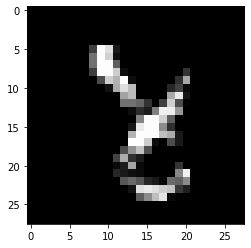

CAE


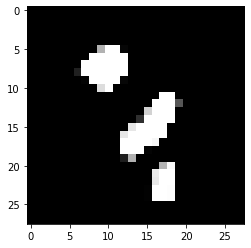

real


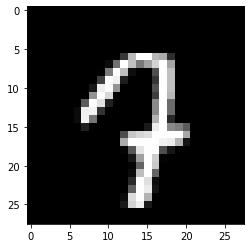

CAE


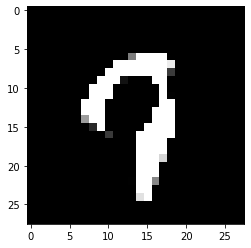

real


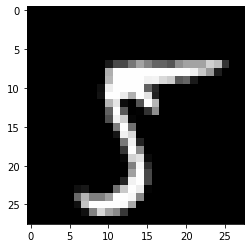

CAE


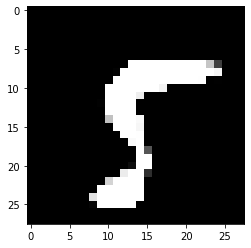

real


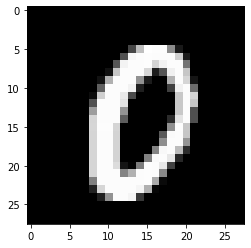

CAE


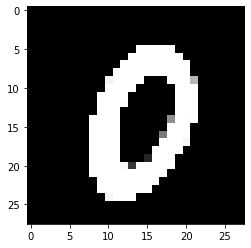

real


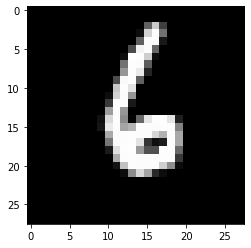

CAE


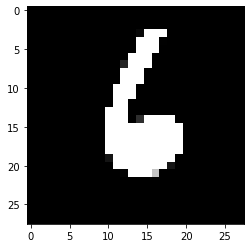

real


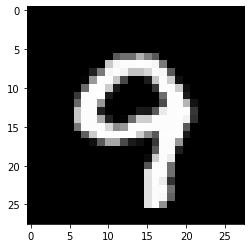

CAE


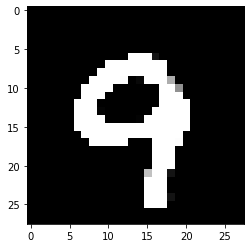

real


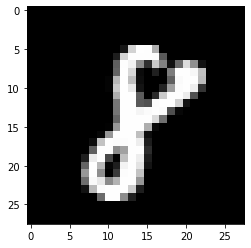

CAE


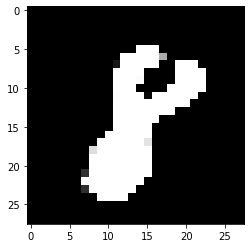

real


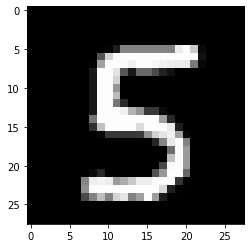

CAE


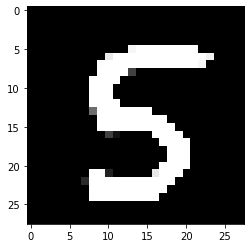

real


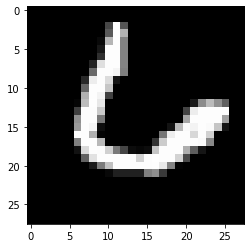

CAE


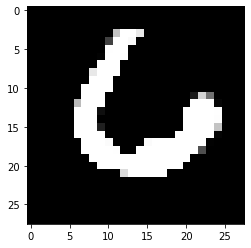

real


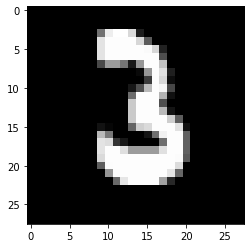

CAE


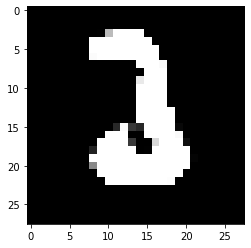

real


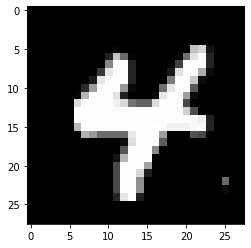

CAE


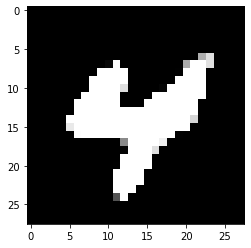

real


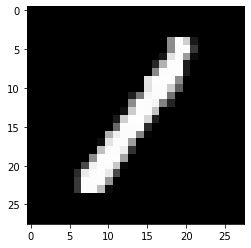

CAE


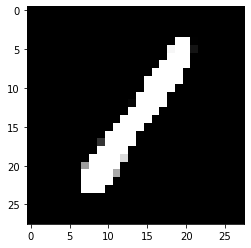

real


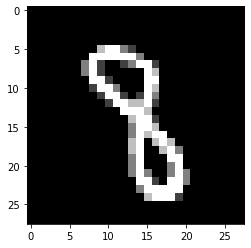

CAE


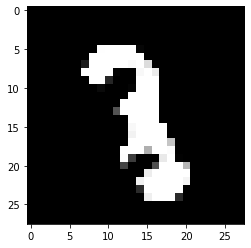

real


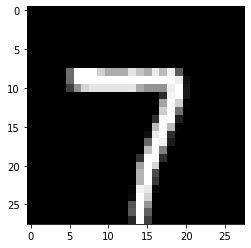

CAE


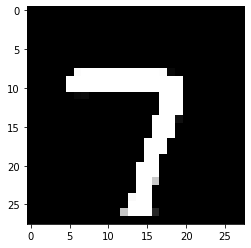

real


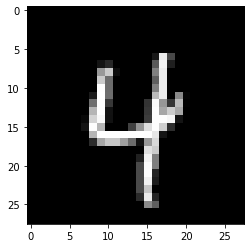

CAE


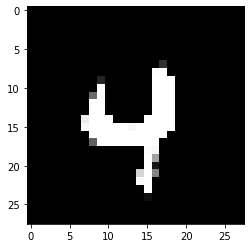

real


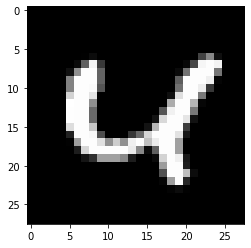

CAE


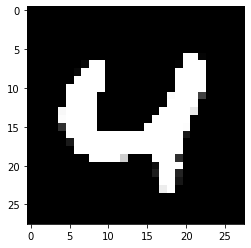

real


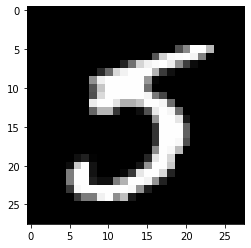

CAE


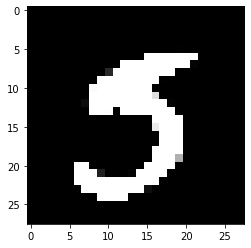

real


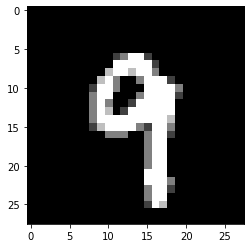

CAE


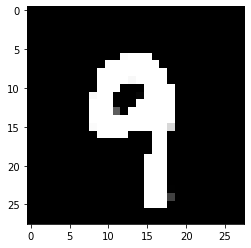

real


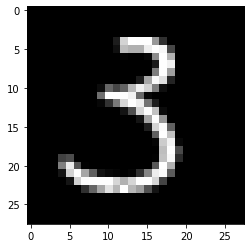

CAE


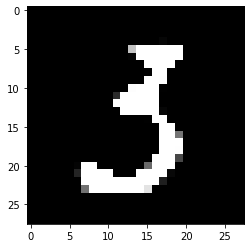

real


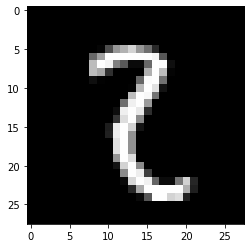

CAE


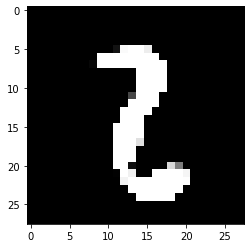

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

for i in range(len(x)):
  img = x[i].numpy().squeeze()#
  vae_img = vae_x[i].cpu().numpy().squeeze()

  print('real')
  
  plt.imshow(img, cmap='gray')
  plt.show()
  print('CAE')
  plt.imshow(vae_img, cmap='gray')
  plt.show()

From what we can see, the convolutional autoencoer seems to do pretty well. Almost every number generated from the convolutional autoencoder seems to be readable. The pixel values for the generated images seem to be higher than the average value of the pixels of the input, are we can see the values on the edges seem to be much whiter than the values in the actual images. Numbers such as 7 that have a line through them in some examples also have been smoothed out, not perfectly reconstructing it but averaging it out.

### 2.4
What similarities and differences are there between a denoising autoencoder and a variational autoencoder?

A variational autoencoder gets some input and between the encoder and decoder, creates a probability distribution of the encoding. This allows VAEs to generate new data, instead of simply reconstructing the inputs.
Denoising autoencoders work by first setting parts of the input to 0 or some other value such as applying a gaussian blur. The ouput of the denoising autoencoder is the uncorrupted image. This allows the autoencoder to recover images that may have been censored or distorted.

## Problem 3
1. Implement an LSTM autoencoder to learn your own word embeddings: Fill in the TODOs in rnn.py to train your own LSTM and learn word embeddings for a custom text file of your choosing.

2. TODO 1: Choose any text you would like and put it into a file in your working directory. Put the name of the file into the variable in this line.

3. TODO 2: Create an embedding matrix with random initial values, using any initializing function you would like. This matrix has a row for each word in the vocabulary, with each row containing a learnable embedding of size EMBEDDING SIZE.

4. TODO 3: Define an LSTM model for an encoder that takes the input embeddings you created in the previous step and produces a final state.

5. TODO 4: Define an LSTM model for a decoder that takes the final state of your encoder and produces a sequence of outputs that will be trained to reproduce the original sequence. You should be able to reuse much or all of the code from the previous part.

6. TODO 5: Plot the word embeddings with the given code. You are able to adjust the plotting pa- rameters to suit your needs for making a compelling visualization. Discuss what you notice in your embeddings.For example, using the introduction to Charles Darwin’s On the Origin of Species as a text file, I obtain this embeddings in Figure 1

7. Since this is too crowded to interpret, we’ve provided code to randomly select words to plot as long as there is space as shown in Figure 2. Either use this code multiple times or create your own code to obtain a visualization(s) that facilitates allows you to learn something about your data. Include this visualization in your report


In [ ]:
from __future__ import unicode_literals, print_function, division

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import re

from io import open
import glob
import os
import unicodedata
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# old_repr = torch.Tensor.__repr__
# def tensor_info(tensor):
#     return repr(tensor.shape)[6:] + ' ' + repr(tensor.dtype)[6:] + '@' + str(tensor.device) + '\n' + old_repr(tensor)
# torch.Tensor.__repr__ = tensor_info


BATCH_SIZE = 10
ITERATIONS = 1000
SEQ_LENGTH = 50
EMBEDDING_SIZE = 100
LSTM_SIZE = 64

# TODO 1: put a text file of your choosing in the same directory and put its name here
TEXT_FILE = 'on the original of species introduction.txt'

string = open(TEXT_FILE).read()

# convert text into tekens
tokens = re.split('\W+', string)

# get vocabulary
vocabulary = sorted(set(tokens))

# get corresponding indx for each word in vocab
word_to_ix = {word: i for i, word in enumerate(vocabulary)}

VOCABULARY_SIZE = len(vocabulary)
print('vocab size: {}'.format(VOCABULARY_SIZE))

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

torch.manual_seed(1)

#############################################
# TODO 2: create variable for embedding matrix. Hint: you can use nn.Embedding for this
#############################################

embeds = nn.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE)


#############################################
# TODO 3: define an lstm encoder function that takes the embedding lookup and produces a final state
# _, final_state = your_lstm_encoder(embedding_lookup_for_x, ...)
#############################################

class Encoder(nn.Module):
    def __init__(self, embeds, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim = embedding_dim

        self.embeds = embeds
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.embedding_dim,
            num_layers=1,
            batch_first=True
        )


    def forward(self, x):
        # batch_size = x.shape[0]
        # x = x.reshape((batch_size, self.seq_len, self.n_features))

        x = self.embeds(x)
        x, (hn, cn) = self.rnn1(x)
        return (hn, cn)


#############################################
# TODO 4: define an lstm decoder function that takes the final state from previous step and produces a sequence of outputs
# outs, _ = your_lstm_decoder(final_state, ...)
#############################################

class Decoder(nn.Module):
    def __init__(self, embeds, seq_len, n_features, hidden_dim, voc_size):
        super(Decoder, self).__init__()
        self.embeds = embeds
        self.seq_len, self.hidden_dim = seq_len, hidden_dim
        self.input_dim = n_features
        self.voc_size = voc_size
        self.lstm_cell = nn.LSTMCell(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
        )

        self.output_layer = nn.Linear(self.hidden_dim, voc_size)

    def forward(self, batch_size, h0_c0):
        x0 = torch.zeros(batch_size, self.input_dim)
        x = x0
        (h, c) = h0_c0

        output = torch.zeros(self.seq_len, batch_size, self.voc_size)
        for i in range(self.seq_len):
            h1, c1 = self.lstm_cell(x, (h, c))
            x2 = self.output_layer(h1)
            max_val, word_idx = torch.max(x2, 1)
            x = self.embeds(word_idx)
            h, c = h1, c1

            output[i, :, :] = x2

        output = torch.transpose(output, 0, 1)

        return output


class RecurrentAutoencoder(nn.Module):
    def __init__(self, embeds, voc_size, seq_len, word_embed_dim, lstm_embed_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.embeds = embeds
        self.encoder = Encoder(embeds, seq_len, word_embed_dim, lstm_embed_dim).to(device)
        self.decoder = Decoder(embeds, seq_len, word_embed_dim, lstm_embed_dim, voc_size).to(device)


    def forward(self, x):
        batch_size = x.shape[0]
        hn, cn = self.encoder(x)
        hn = torch.squeeze(hn)
        cn = torch.squeeze(cn)
        x = self.decoder(batch_size, (hn, cn))

        return x


model = RecurrentAutoencoder(embeds, VOCABULARY_SIZE, SEQ_LENGTH, EMBEDDING_SIZE, LSTM_SIZE)


# helper function
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot


#############################################
# TODO: create loss/train ops
#############################################


# ex.
# loss_fn = nn.BCELoss()
# loss = loss_fn(out,one_hots)
# optimizer = optim.Adam(model.parameters(),lr=0.01)
# do training

embeddings_init = model.embeds.weight.detach().clone()
# linear_output_init = model.output.weight.detach().clone()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1)

losses = []

i = 0
for num_iter in range(ITERATIONS):

    if num_iter % 10 == 0:
        print(num_iter)

    batch = [[vocabulary.index(v) for v in tokens[ii:ii + SEQ_LENGTH]] for ii in range(i, i + BATCH_SIZE)]
    batch = np.stack(batch, axis=0)
    batch = torch.tensor(batch, dtype=torch.long)
    i += BATCH_SIZE
    if i + BATCH_SIZE + SEQ_LENGTH > len(tokens): i = 0

    #############################################
    # TODO: create loss and update step
    #############################################

    # Hint:following steps will most likely follow the pattern
    # out = model(batch)
    # loss = loss_function(out,batch)
    # optimizer.step()
    # optimizer.zero_grad()

    optimizer.zero_grad()
    log_probs = model(batch)
    loss = loss_function(torch.reshape(log_probs, (-1, VOCABULARY_SIZE)), batch.view(-1))
    loss.backward()
    optimizer.step()

    losses.append(loss.item())



vocab size: 630
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


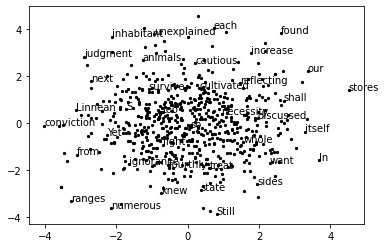

In [ ]:

learned_embeddings = model.embeds.weight.detach()
# linear_output = model.output.weight.detach()

# diff_embedding = (embeddings_init - learned_embeddings).abs().mean()
# diff_output = (linear_output_init - linear_output).abs().mean()

# print(diff_embedding)
# print(diff_output)

learned_embeddings = learned_embeddings.detach().numpy()

fig = plt.figure()
learned_embeddings_pca = sklearn.decomposition.PCA(2).fit_transform(learned_embeddings)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=5, c='k')
MIN_SEPARATION = .1 * min(ax.get_xlim()[1] - ax.get_xlim()[0], ax.get_ylim()[1] - ax.get_ylim()[0])

fig.clf()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=5, c='k')


xy_plotted = set()
for i in np.random.choice(VOCABULARY_SIZE, VOCABULARY_SIZE, replace=False):
    x_, y_ = learned_embeddings_pca[i]
    if any([(x_ - point[0])**2 + (y_ - point[1])**2 < MIN_SEPARATION for point in xy_plotted]): continue
    xy_plotted.add(tuple([learned_embeddings_pca[i, 0], learned_embeddings_pca[i, 1]]))
    ax.annotate(vocabulary[i], xy=learned_embeddings_pca[i])


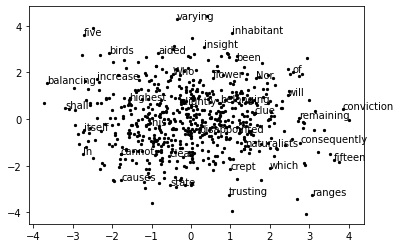

In [ ]:
learned_embeddings = model.embeds.weight.detach()
# linear_output = model.output.weight.detach()

# diff_embedding = (embeddings_init - learned_embeddings).abs().mean()
# diff_output = (linear_output_init - linear_output).abs().mean()

# print(diff_embedding)
# print(diff_output)

learned_embeddings = learned_embeddings.detach().numpy()

fig = plt.figure()
learned_embeddings_pca = sklearn.decomposition.PCA(2).fit_transform(learned_embeddings)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=5, c='k')
MIN_SEPARATION = .1 * min(ax.get_xlim()[1] - ax.get_xlim()[0], ax.get_ylim()[1] - ax.get_ylim()[0])

fig.clf()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(learned_embeddings_pca[:, 0], learned_embeddings_pca[:, 1], s=5, c='k')


xy_plotted = set()
for i in np.random.choice(VOCABULARY_SIZE, VOCABULARY_SIZE, replace=False):
    x_, y_ = learned_embeddings_pca[i]
    if any([(x_ - point[0])**2 + (y_ - point[1])**2 < MIN_SEPARATION for point in xy_plotted]): continue
    xy_plotted.add(tuple([learned_embeddings_pca[i, 0], learned_embeddings_pca[i, 1]]))
    ax.annotate(vocabulary[i], xy=learned_embeddings_pca[i])


## Problem 4
1. Graph convolutional networks are modeled explicitly after classical CNNs. The graph domain, however, poses unique challenges: whereas every pixel in an image is connected to its neighbors in the same way, nodes in a graph exhibit a range of local structures that make it impossible to define a convolutional operator as a dot product with a filter. How does the GCN of Kipf and Welling draw upon spectral graph theory to overcome these difficulties? Are there any problems with this approach? (Bonus: what alternate ways exist of defining convolutions in the graph domain?)
For reference, see the paper that introduced the first GCN,“Kipf2017: Semi-Supervised Classification with Graph Convolutional Networks”. You may also enjoy this article, which reviews Kipf and Welling’s approach: “How Powerful are Graph Convolutional Networks?".

How does the GCN of Kipf and Welling draw upon spectral graph theory to overcome these difficulties?

- Answer: Kipf and Welling use the spectral graph theory to define a convolutional operator. The theory defines a Fourier transform of the signal on a graph using eigenvectors from the graph Laplacian matrix. After transforming the signal to the frequency domain, convolution in the spatial domain becomes multiplication of the transformed signal and the transformed filter. The transformed filter can be approximated using Chebyshev polynomials. Kipf and Welling use the first two order polynomials to approximate the transformed filter, which suffers from the fact that the convolution kernel is isotropic.

Are there any problems with this approach?

- Answer: The main problem of Kipf and Welling’s approximation is that the convolution kernel is isotropic if only the first two order polynomials are used. It means that the convolution can not detect directional changes like CNN.

 

What alternate ways exist of defining convolutions in the graph domain?

- Answer: We can also do convolution in the spatial domain. Suppose the graph lies on a low dimensional manifold and locally there is a chart that maps the points in a neighborhood to the Euclidean space. Then convolution can be defined in the Euclidean space and also apply to the graph nodes via the chart function.

 



2. PyTorch Geometric is a powerful library that makes building GNNs as easy as building CNNs with PyTorch. Follow the (rather involved) installation instructions to set it up on your machine. (Tip: You can set the variables TORCH and CUDA by running TORCH="1.8.0" and CUDA="cpu" in the command line.) While you wait for the packages to download, I suggest reading through the brief Introduction by Example to familiarize yourself with PyTorch Geometric’s conventions of graph usage.

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.6-cp37-cp37m-linux_x86_64.whl size=2886235 sha256=c3b75aec15521618507eed123cffa5ad0262dc0b962d20852d69793e8422027a
  Stored in directory: /root/.cache/pip/wheels/d6/bf/04/7c9e0c1466d37548e5c7c7c2daee2b7f90ce616f102c68bf07
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
  Created wheel for torch-sparse: filename=torch_sparse-0.6.9-cp37-cp37m-linux_x86_64.whl size=1226688 sha256=8a6715db8178d16ca423a0649b304acc3d17029f2264784a222852b949b1498f
  Stored in directory: /root/.cache/pip/wheels/6c/9f/3e/8813c1f7e87d12b01b830d3506e7f3f6b044d9d53769057ddb
Successfully built torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html
^C
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+10.1.html


3. Fill out the skeleton code in GCN.py to build a more powerful variant of Kipf and Welling’s GCN, as proposed in Xu et al’s “How Powerful Are Graph Neural Networks?”. You can follow the Pytorch Geometric tutorial on Creating Message Passing Networks, but please make these modifications to the tutorial’s baseline:

- For $\gamma$, use a multi-layer perceptron network.

- Do not perform any normalization in the aggregation step, φ.


In [ ]:
#gcn.py
# GCNs.py - First created by Kincaid MacDonald in Spring 2021.
# Deep Learning Theory and Applications - Assignment 4.
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import global_add_pool, global_mean_pool

# This is the standard GCN Convolutional layer from Kipf & Welling. You will use it in your experiments,
# but the assignment asks you to adapt this into a more powerful GNN, using the skeleton class below
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

# TODO: Adapt the GCNConv class with the modifications suggested by the pset. Refer to https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html for details on the MessagePassing class
class BetterGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(BetterGCNConv, self).__init__(aggr='max')
        self.mlp = Seq(Linear(2 * in_channels, in_channels),
                       ReLU(),
                       Linear(in_channels, out_channels))
        

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        # x = self.mlp(x)

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        # print(tmp.shape())
        return self.mlp(tmp)




# These are the network classes: they combine the message-passing layers defined above just as a CNN combines convolutional layers.
class NodeClassifier(torch.nn.Module):
    def __init__(self, num_node_features, hidden_features, num_classes):
        super(NodeClassifier, self).__init__()
        self.conv1 = BetterGCNConv(num_node_features, hidden_features)
        self.conv2 = BetterGCNConv(hidden_features, num_classes)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class GraphClassifier(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GraphClassifier, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = BetterGCNConv(num_node_features, hidden_channels)
        self.conv2 = BetterGCNConv(hidden_channels, hidden_channels)
        self.conv3 = BetterGCNConv(hidden_channels, hidden_channels)
        self.conv4 = BetterGCNConv(hidden_channels, hidden_channels)
        self.conv5 = BetterGCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)
        self.bn = nn.BatchNorm1d(hidden_channels, affine=False)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv5(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0, training=self.training)
        x = self.lin(x)

        return x

class GraphClassifier2(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GraphClassifier2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)
        self.bn = nn.BatchNorm1d(hidden_channels, affine=False)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = self.bn(x)
        x = x.relu()
        x = self.conv5(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0, training=self.training)
        x = self.lin(x)

        return x

4. Put your newly-hewn GCN to work by running NodeClassification.py. This script imports the GCN you built in the previous section, and trains it on the CORA citation network. Each node in the CORA graph is an academic paper, linked to those nodes it cites (or is cited by), and accompanied by a bag-of-words feature vector. Your network’s task is to predict the category of each paper. After training your modified version of the GCN on CORA, train a clone of your model that uses the original GCNConv layers (of Kipf and Welling). How does its performance compare to our modified version?

Following the tutorial for edge convolution, which removes the normalization and uses a mlp for γ instead of a linear layer, we get results worse than the standard GCNConv in the first part of the tutorial, the baseline. Running on the edge convolution, we get an accuracy of ~31%. However, on the baseline we get an accuracy of ~80%. Trying different hyperparameters such as the number of layers in the mlp and the number of neurons seems to make minimal difference for the edge convolutional network. 

In [ ]:
# This data handling code is adapted from the PyTorch geometric collection of google colab notebooks, a fantastic resource for getting started with GNNs. https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import DataLoader
# import the graph classifier you built in the last step
from GCN import NodeClassifier

# - - - DATA PREPARATIONS - - -

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Finally, we've got the train loader and the test loader! Time to start doing the actual training!
# "A data scientist's job is 90% data, 10% science"
# - - - TRAINING - - -

model = NodeClassifier(num_node_features=1433, hidden_features=16, num_classes=7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask],
                     data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc}')

5. Using GraphClassification.py, train your hand-built GCN on the REDDIT-BINARY dataset for 100 epochs. Each graph in this dataset depicts a single discussion thread on Reddit, with edges connecting those users who replied to each other’s comments. The task is to predict which community the thread comes from. After you have trained your modified GCN on the dataset, once again replace the BetterGCNConv layers in the GraphClassifier class with standard GCNConv layers and train the original Kipf and Welling GCN on the Reddit dataset (again, for a full 100 epochs). Report the accuracies for each. How do you explain any differences?

The accuracy for the "better" network was 49.4%. The accuracy for the baseline was 50.6%. Both of these accuracies are very close. Based on the poor performance of the better network in the CORA task, I expected the difference to be much greater. However, it seems like neither network was able to do any better than random guessing on this task.

In [ ]:
# This data handling code is adapted from the PyTorch geometric collection of google colab notebooks, a fantastic resource for getting started with GNNs. https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Constant
# import the graph classifier you built in the last step
from GCN import GraphClassifier, GCNGraphClassifier

# - - - DATA PREPARATIONS - - -
dataset = TUDataset(
    root='data/TUDataset',
    name='REDDIT-BINARY',
    pre_transform=Constant() # the Reddit dataset has no node features of its own. This "Constant" pre-transform gives each node the value '1'.
    # If all goes according to plan, the GCN should be able to derive good graph representations from the connectivity of the graphs alone.
)
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

torch.manual_seed(12345) # for reproducibility
dataset = dataset.shuffle()

train_dataset = dataset[:1000]
test_dataset = dataset[1000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Finally, we've got the train loader and the test loader! Time to start doing the actual training!
# "A data scientist's job is 90% data, 10% science"
# - - - TRAINING - - -

model = GCNGraphClassifier(hidden_channels=64, num_node_features=1, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(1, 201):
    train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [ ]:
# This data handling code is adapted from the PyTorch geometric collection of google colab notebooks, a fantastic resource for getting started with GNNs. https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Constant
# import the graph classifier you built in the last step
#rom GCN import GraphClassifier, GCNGraphClassifier

# - - - DATA PREPARATIONS - - -
dataset = TUDataset(
    root='data/TUDataset',
    name='REDDIT-BINARY',
    pre_transform=Constant() # the Reddit dataset has no node features of its own. This "Constant" pre-transform gives each node the value '1'.
    # If all goes according to plan, the GCN should be able to derive good graph representations from the connectivity of the graphs alone.
)
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

torch.manual_seed(12345) # for reproducibility
dataset = dataset.shuffle()

train_dataset = dataset[:1000]
test_dataset = dataset[1000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Finally, we've got the train loader and the test loader! Time to start doing the actual training!
# "A data scientist's job is 90% data, 10% science"
# - - - TRAINING - - -

model = GraphClassifier2(hidden_channels=64, num_node_features=1, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(1, 100):
    train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')